# TPS_Apr_2022💓💓Tsfresh💦💦


<div class="alert alert-block alert-info"> 
<br>This month's challenge is time series classification problem.
<br>the biological sensor data recorded from several participants who could have been in either of two possible activity states.
</div>


Electrocardiogram (ECG) examines heart rate and heart rhythm.
> It can help detect problems with your heart.

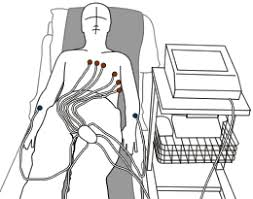
Sensor,s name is V1 to V6, aVL, -aVR, aVf, Ⅰ, ⅠⅠ, Ⅲ. 
> 1. Right cornary artery(RCA) : ⅠⅠ, Ⅲ, aVF
> 1. Left main trank(LMT) : V1, V2, V3, V4
> 1. Left cirumflex coronary artery(LCX) : Ⅰ, aVL, V5, V6

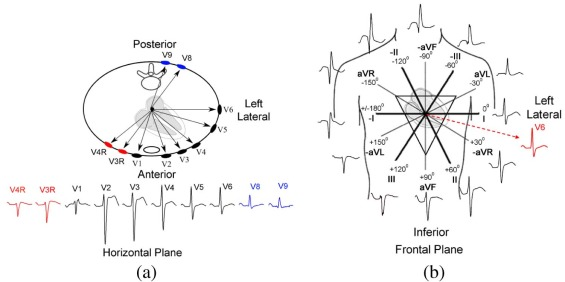

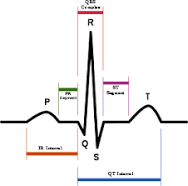
< - Normal pattern. 
>  Waveforms can be diagnosed from width, height and time.
 
<span style="color:Red;"><br>Diagnostic Flow Chart</span>
1. P-Wave and R-Wave --> Not constant?
1. PQ time --> Longer?
1. R-Wave --> Heiger?
1. QR --> Wider?
1. ST --> Fall below the level or up?
1. T-Wave --> Flat or Negative?
> If any of the above applies. It could be possible Cardiac(myocardial)infarction, Heart attack,stroke or other heart disease sush as enlargement of heart,arrhythmia or hyperpotassemia,etc. 

In [ ]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython import get_ipython
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
from sklearn import metrics

from tsfresh.transformers import RelevantFeatureAugmenter

import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

=================================
# EDA 📈📊

In [ ]:
data_dir = Path('../input/tabular-playground-series-apr-2022')
train = pd.read_csv(data_dir / 'train.csv')
test = pd.read_csv(data_dir / 'test.csv')
labels = pd.read_csv(data_dir / 'train_labels.csv')

In [ ]:
train[58:63].T

In [ ]:
train.info()

In [ ]:
train.describe().T

In [ ]:
# sensor 
figure = plt.figure(figsize=(16, 12))
for i in range(13):
    sensor_name = f'sensor_{i:02d}'
    plt.subplot(4, 4, i+1)
    plt.hist(train[sensor_name], bins = 50)
    plt.title(f'{sensor_name}')
    plt.suptitle("Sensor Value")
figure.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

In [ ]:
train.quantile([0.05,0.95]).T

In [ ]:
# 5% ~ 95%
figure = plt.figure(figsize=(16, 12))
for i in range(13):
    sensor_name = f'sensor_{i:02d}'
    plt.subplot(4, 4, i+1)
    plt.hist(train[sensor_name], bins=50, range=(train[sensor_name].quantile(0.05), train[sensor_name].quantile(0.95)))
    plt.title(f'{sensor_name}')
    plt.suptitle("Sensor quantization value")
figure.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

In [ ]:
train.kurt()

+++++++++++++++++++++++++++++++++++++

In [ ]:
test[58:63].T

In [ ]:
test.info()

In [ ]:
test.describe().T

In [ ]:
figure = plt.figure(figsize=(16, 12))
for i in range(13):
    sensor_name = f'sensor_{i:02d}'
    plt.subplot(4, 4, i+1)
    plt.hist(test[sensor_name], bins = 50)
    plt.title(f'{sensor_name}')
    plt.suptitle("Sensor value")
figure.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

In [ ]:
figure = plt.figure(figsize=(16, 12))
for i in range(13):
    sensor_name = f'sensor_{i:02d}'
    plt.subplot(4, 4, i+1)
    plt.hist(test[sensor_name], bins=50, range=(test[sensor_name].quantile(0.05), test[sensor_name].quantile(0.95)))
    plt.title(f'{sensor_name}')
    plt.suptitle("Sensor quantization value")
figure.tight_layout(h_pad=0.5, w_pad=0.5)
plt.show()

++++++++++++++++++++++++++++++++++

In [ ]:
labels.state

In [ ]:

labels.state.hist()
plt.title('Target', fontsize=16)
plt.show()

<div 
State is almost the same values.

+++++++++++++++++++++++++++++++++

In [ ]:
sequence = [1,11,33,70,86,256]
for i in range(len(sequence)):
    state =  labels[labels.sequence== sequence[i]]["state"].values[0]
    train[train['sequence'] == sequence[i]].plot(subplots = True, sharex = True, figsize = (8,12))
    plt.suptitle(f"sequence {sequence[i]} state {state}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()  

<div class="alert alert-block alert-info"> 
    <br> train's sequence values is  1558080 
    <br> test's sequence value is  733080 and a continuation of train.
    <br> Train's subject value is 671. 
    <br> Test's subject value is 990. 
    <br> Target(state) is almost the same values.
    <br> 13(sensor)x 60(step) x 671(subject) = 523380 ? It doesn't match the sequence values.🤔
    <br> Sequences 11 and 33 have the same subject number. So some suject seem to be included several times in the sequence.
    <br> Data values for some sensors exceed 100, and state is 1.
    <br> However,I'm not sure how to determine the correct State.🤷‍♀️</br>
    
    

In [ ]:
#  memory  release
del train
del test
del labels

==============================
# Tsfresh
* This time, I tried 'Tsfresh' method.
* This method is automatically calculates a large number of time series features 
* [Tsfresh](https://tsfresh.readthedocs.io/en/latest/text/sklearn_transformers.html)
*   [@RYAN HOLBROOK  tps-april-2022-benchmark](https://www.kaggle.com/code/ryanholbrook/tps-april-2022-benchmark)

In [ ]:
df_train = pd.read_csv(data_dir / 'train.csv',index_col=['sequence', 'subject', 'step'])
labels = pd.read_csv(data_dir / 'train_labels.csv', index_col='sequence').squeeze()

In [ ]:
# Reduce memory usage
# train features
for col in df_train.columns:
    if df_train[col].dtype == "float64":
        df_train[col]=pd.to_numeric(df_train[col], downcast="float")
    if df_train[col].dtype == "int64":
        df_train[col]=pd.to_numeric(df_train[col], downcast="integer")


In [ ]:
df_train.info()

In [ ]:
# Mask
#for sensor in range(13):
   #sensor_name = f'sensor_{sensor:02d}'

    #df_train[sensor_name] = df_train[sensor_name].mask(df_train[sensor_name] < -100 ,- 100)
    #df_train[sensor_name] = df_train[sensor_name].mask(df_train[sensor_name]  > 100 , 100)

* This time no masking version.

<div class="alert alert-block alert-info"> 
    <br>This time, Some of the values were considered outliers, so I used a masking technique on this data.
    <br>An error value may be due to abnormal electrode attachment.
    <br>I wonder this unusual numbers might be important or not?
    
</div>

In [ ]:
df_train.describe().T

In [ ]:
def score(model, X_test, y_test, X_train=None, y_train=None, fitted=True):
    #from sklearn import metrics

    if not fitted:
        model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    
    print('Acc\t', metrics.accuracy_score(y_test, y_pred.round()))
    print('AUC:\t', metrics.roc_auc_score(y_test, y_pred))
    print('AP:\t', metrics.average_precision_score(y_test, y_pred))
    print('Rec:\t', metrics.recall_score(y_test, y_pred.round()))
    print('Prec:\t', metrics.precision_score(y_test, y_pred.round()))
    print('F1:\t', metrics.f1_score(y_test, y_pred.round()))

In [ ]:
N_SEQS = 12000  # Only use a subset of the sequences for the sake of time
TEST_SIZE = 0.2

sequences, subjects = (
    df_train
    .reset_index()
    .loc[:, ['sequence', 'subject']]
    .drop_duplicates()
    .to_numpy()
    [: N_SEQS]
    .T
)

splitter = GroupShuffleSplit(test_size=TEST_SIZE, n_splits=1, random_state = 0)
seq_train, seq_valid = next(splitter.split(sequences, groups=subjects))

X_train, X_valid = df_train.loc[seq_train], df_train.loc[seq_valid]
y_train, y_valid = labels.loc[seq_train], labels.loc[seq_valid]

display(X_train)
display(y_train)


In [ ]:
#N_SENSORS = 13 # all swensors
#features = [f'sensor_{k:02d}' for k in range(N_SENSORS)]

N_SENSORS = [0,1,2,3] # you may change if you want 

features = [f'sensor_{k:02d}' for k in N_SENSORS]
X_train = X_train.reset_index().loc[:, ['sequence', 'step'] + features]
X_valid = X_valid.reset_index().loc[:, ['sequence', 'step'] + features]

# Extra (non-time series) features go here.
# There are none, so we'll create dummy frames to satisfy the arguments of the fit/predict methods.
Xtra_train = pd.DataFrame(np.zeros_like(y_train), index=y_train.index)
Xtra_valid = pd.DataFrame(np.zeros_like(y_valid), index=y_valid.index)

model = Pipeline([
    ('augmenter', RelevantFeatureAugmenter(column_id='sequence', column_sort='step')),
    ('hgb', HistGradientBoostingClassifier()),
    #'rf', RandomForestClassifier(n_jobs=-1)),
]) 

model.set_params(augmenter__timeseries_container=X_train)
model.fit(Xtra_train, y_train)

model.set_params(augmenter__timeseries_container=X_valid)
score(model, Xtra_valid, y_valid)


In [ ]:
test = pd.read_csv(data_dir / 'test.csv',index_col=['sequence', 'subject', 'step'])

In [ ]:
# Mask
#for sensor in range(13):
    #sensor_name = f'sensor_{sensor:02d}'

    #test[sensor_name] = test[sensor_name].mask(test[sensor_name] < -100 ,- 100)
    #test[sensor_name] = test[sensor_name].mask(test[sensor_name]  > 100 , 100)

In [ ]:
test.describe().T

In [ ]:
# Reduce memory usage
# test features
for col in test.columns:
    if test[col].dtype == "float64":
        test[col]=pd.to_numeric(test[col], downcast="float")
    if test[col].dtype == "int64":
        test[col]=pd.to_numeric(test[col], downcast="integer")

In [ ]:
test.info()

===================================
# Submission

In [ ]:
sub = pd.read_csv(data_dir / 'sample_submission.csv', index_col=['sequence'])

X_test = test.reset_index().loc[:, ['sequence', 'step'] + features]
Xtra_test = pd.DataFrame(np.zeros_like(sub), index = sub.index)

model.set_params(augmenter__timeseries_container=X_test)
sub['state'] = model.predict_proba(Xtra_test)[:, 1]

sub.to_csv('submission_0123.csv')

In [ ]:
sub.head(10)

In [ ]:
sub.describe()

In [ ]:
state_counts_1 = sub.state.value_counts(sort=False).reset_index().rename(columns={"state":"count","index":"state"})

sns.scatterplot(data = state_counts_1, x="state", y="count")
plt.title("tsfresh 0123")

+++++++++++++++++++++

In [ ]:
sub_a = pd.read_csv('../input/tps-apr-2022-tsfresh-9/submission_45678.csv',index_col=['sequence'])
sub_b = pd.read_csv('../input/tps-apr-2022-tsfresh/submission_9101112.csv',index_col=['sequence'])

In [ ]:
sub_a.head(10)

In [ ]:
sub_a.describe()

In [ ]:
sub_b.head(10)

In [ ]:
sub_b.describe()

In [ ]:
state_counts_2 = sub_a.state.value_counts(sort=False).reset_index().rename(columns={"state":"count","index":"state"})

sns.scatterplot(data = state_counts_2, x="state", y="count")
plt.title("tsfresh 45678")

In [ ]:
state_counts_3 = sub_b.state.value_counts(sort=False).reset_index().rename(columns={"state":"count","index":"state"})

sns.scatterplot(data = state_counts_3, x="state", y="count")
plt.title("tsfresh 9101112")

++++++++++++++++++++++

In [ ]:
sub['state'] = (sub['state']*0.35) + (sub_a['state']*0.32) +(sub_b['state']*0.33)
sub.head(10)

In [ ]:
sub.to_csv('submission.csv')

* Update!
> This time, I tried RandomForestClassier. score is 0.899.
* Update again!
> This time, I back to HistGradientBoostingClassifier. It change the masking range and sensor number.
> It gave a good score(AUC 0.94), but it used a limited number of sensors. 
* Update!
> This time, I tried 6 sensors. Memory usage was just barely adequate. AUC is 0.89.
* Update!
> I added the value of sensors with even sensor numbers, excluding only the sensor_02 because its shape is different from the other waves. However it will be interesting to see how the score changes if the sensor_02 is added. 
* Update!
> I found a mistake. sorry.😣 This time, No masking version.
* Update!
> I tried sensor's number 0 to 6(exclude 2) and 7 to 12. AUC is 0.924 and 0.929.
> This score is the same as result the odd and even versions.
* Update! may be final? or...
> I tried sensor's number 0 to 4, 5 to 8, and 9 to 12. AUC is 0.936, 0.862 and 0.923. And the result is 0.942
* Update! 
> I tried sensor's number 0 to 3 , 4 to 8 and 9 to 12. AUC is 0.89, 0.925 and 0.923.
* **in progress..**


<div class="alert alert-block alert-info">
     <span style="color:blue;"><br>Conclusion</span>
    <br>This time, I chose a limited number of sensors to test. If you have the time and specs, try it with all sensors.
   <br>I tried RFC(RandomForestClassifier) too, it did't make much difference in time.
   <br> HGBC(HistGradientBoostingClassifier)'s result is a little better than RFC.
    <br>In this case,I used a mask to process the data.The results are better than not.
    <br>You may want tro try other models. Maybe you will get a better results.
    <br>'Tsfresh' is automatically calculates a large number of time series features. It will take time, but I thought it was a useful method.</br>
    <span style="font-family:cursive;"><br>GoodLuck!</span>
   <br>Thank you for reading!</br>
</div>